In [1]:
import torch 
import numpy 
import os 
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np

In [2]:
model = 'resnet18'
order='bw'
direction='in'

features = [] 
sample_path = os.path.join('results', model, f"{order}_{direction}")
layer_results_temp = {} # layer : [0~9999, 10000~19999, ...] 
for sample in tqdm(os.listdir(sample_path)):
    f = pickle.load(open(os.path.join(sample_path, sample), 'rb'))
    layer, sample_index = sample.split(".")[0].split("_") 
    if layer not in layer_results_temp.keys():
        layer_results_temp[layer] = [] 
    layer_results_temp[layer].append(f)


100%|██████████| 36/36 [00:00<00:00, 39.63it/s] 


In [3]:
for k in layer_results_temp.keys():
    # print(np.concatenate(layer_results_temp[k], axis=0).shape)
    layer_results_temp[k] = np.concatenate(layer_results_temp[k], axis=0) # 50000 x Channels x Samples 

In [4]:
layer_results = layer_results_temp
layer_results.keys()

dict_keys(['1', '3', '6', '8', '9', '12', '14', '16'])

In [41]:
def hist_plot(channel_rv, ax, max_channels=30, num_features=1000, **kwargs):
    channel_rv = channel_rv.permute(1,0,2,3)
    channel_rv = channel_rv.reshape(channel_rv.size(0), -1)
    # print("Running histplot of size", channel_rv.size())
    c_indcies = np.random.choice(range(channel_rv.size(0)), min(channel_rv.size(0), max_channels), replace=False)
    for i in c_indcies:
        f_indices = np.random.choice(range(channel_rv.size(1)), num_features, replace=False)
        ax.hist(channel_rv[i, f_indices], **kwargs)

def plot_var(channel_rv, ax,  **kwargs):
    channel_rv = channel_rv.transpose(1,0) # Channel x Sample x Dim 
    # channel_rv = channel_rv.reshape(channel_rv.size(0), -1)
    # print("Running Var Computation of size", channel_rv.size())
    # c_indcies = np.random.choice(range(channel_rv.size(0)), min(channel_rv.size(0), max_channels), replace=False)
    variances = [] 
    for i in range(channel_rv.shape[0]):
        cur_features = channel_rv[i]
        variances.append(np.var(cur_features))
    ax.plot(sorted(variances))
    ax.set_title(f"{min(variances):.2E}\n~\n{max(variances):.2E}")

def plot_mean(channel_rv, ax,  **kwargs):
    channel_rv = channel_rv.transpose(1,0) # Channel x Sample x Dim 
    # channel_rv = channel_rv.reshape(channel_rv.size(0), -1)
    # print("Running Var Computation of size", channel_rv.size())
    # c_indcies = np.random.choice(range(channel_rv.size(0)), min(channel_rv.size(0), max_channels), replace=False)
    variances = [] 
    for i in range(channel_rv.shape[0]):
        cur_features = channel_rv[i]
        variances.append(np.mean(cur_features))
    ax.plot(sorted(variances))
    ax.set_title(f"{min(variances):.2E}\n~\n{max(variances):.2E}")
    
def plot_sns_mean_var(channel_rv, ax, **kwargs):
    channel_rv = channel_rv.transpose(1,0) # Channel x Sample x Dim 
    # channel_rv = np.linalg.norm(channel_rv, axis=-1)
    # channel_rv = np.abs(channel_rv)
    # channel_rv = np.sum(channel_rv, axis=-1)
    # print(channel_rv.shape)
    # channel_rv = channel_rv[:,np.random.choice(range(50000), 1000, replace=False),:50]
    
    # channel_rv = channel_rv.reshape(channel_rv.shape[0], -1)
    # channel_rv = channel_rv[:, :50]
    # print(channel_rv.shape)
    # print("Running Var Computation of size", channel_rv.size())
    means = [] 
    dic = {"channel":[],
           "value":[]}
    channel_rv = channel_rv[np.random.choice(range(channel_rv.shape[0]), 15, replace=False)]
    for i in range(channel_rv.shape[0]):
        cur_features = channel_rv[i]
        for v in cur_features:
            dic['channel'].append(i)
            dic['value'].append(v)
    df = pd.DataFrame(dic)
    del dic
    sns.boxplot(data=df, x='channel', y='value', ax=ax,  showfliers = False)

8it [00:15,  2.00s/it]


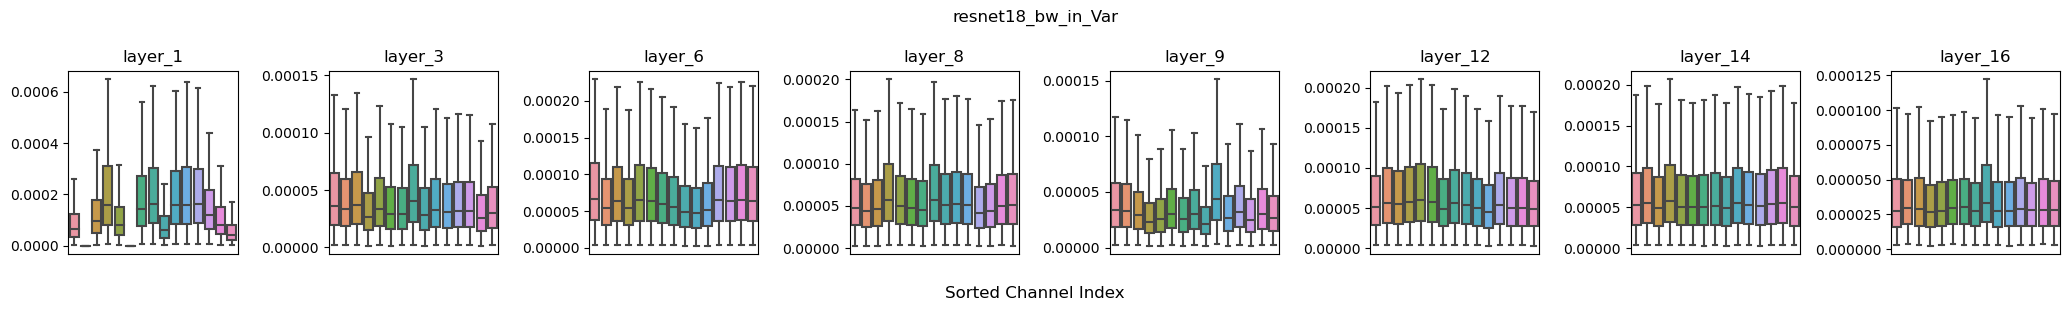

In [44]:

target_layers = layer_results.keys()
fig, axes = plt.subplots(1, len(target_layers), figsize=(len(target_layers)*2.6, 3))
axes_flat = axes.flat
fig.suptitle(f"{model}_{order}_{direction}_Var")
fig.supxlabel("Sorted Channel Index")
# fig.supylabel("Var")

for j, target_layer in tqdm(enumerate(target_layers)): 
    channel_rv = layer_results[target_layer]
    ax = next(axes_flat)
    ax.set_title(f'layer_{target_layer}')
    
    plot_sns_mean_var(channel_rv, ax, alpha=0.5,)
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylabel("")
plt.tight_layout()
plt.savefig(f'results/{model}_{order}_{direction}_Var.pdf')

100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


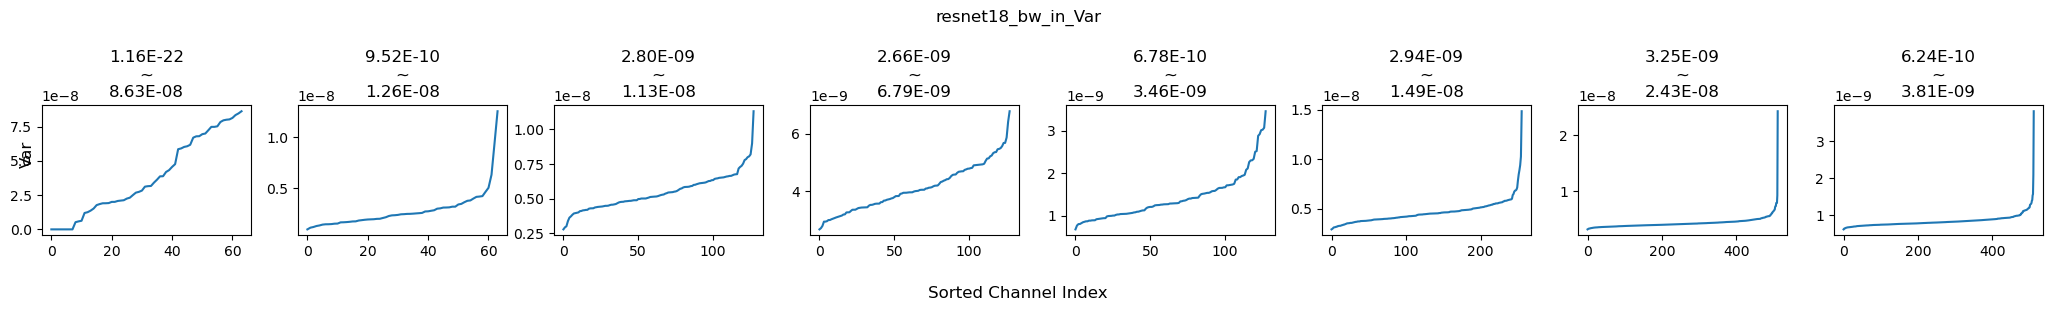

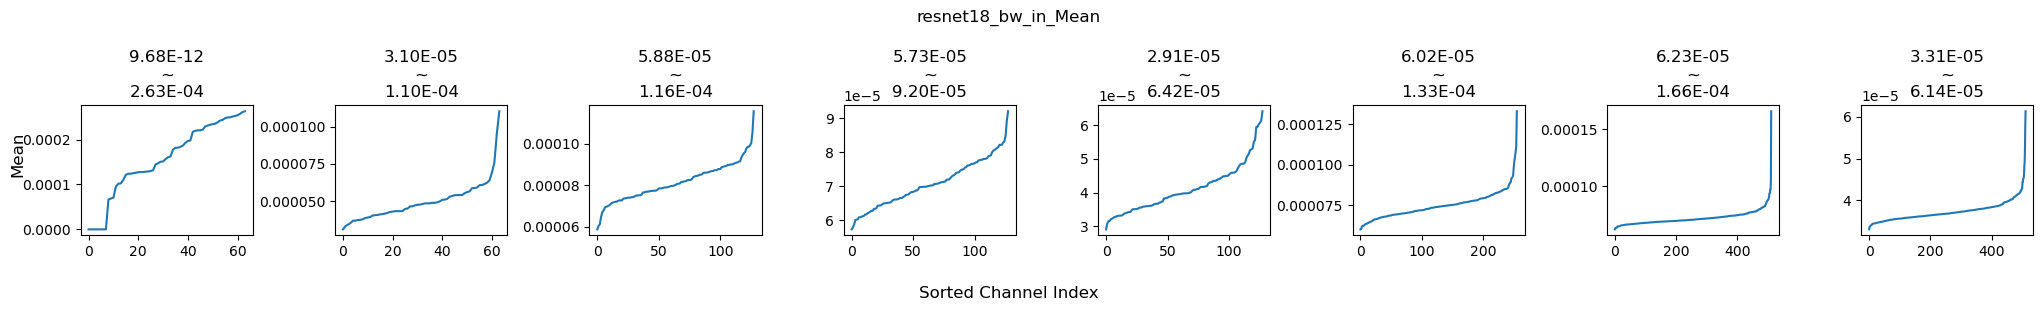

In [14]:
# Var Plot
target_layers = layer_results.keys()
fig, axes = plt.subplots(1, len(target_layers), figsize=(len(target_layers)*2.6, 3))
axes_flat = axes.flat
fig.suptitle(f"{model}_{order}_{direction}_Var")
fig.supxlabel("Sorted Channel Index")
fig.supylabel("Var")

for target_layer in tqdm(target_layers): 
    channel_rv = layer_results[target_layer]
    ax = next(axes_flat)
    ax.set_title(f'layer_{target_layer}')
    plot_var(channel_rv, ax, alpha=0.5, )
plt.tight_layout()

# Mean Plot
fig, axes = plt.subplots(1, len(target_layers), figsize=(len(target_layers)*2.6, 3))
axes_flat = axes.flat
fig.suptitle(f"{model}_{order}_{direction}_Mean")
fig.supxlabel("Sorted Channel Index")
fig.supylabel("Mean")


for target_layer in target_layers: 
    channel_rv = layer_results[target_layer]
    ax = next(axes_flat)
    ax.set_title(f'layer_{target_layer}')
    plot_mean(channel_rv, ax, alpha=0.5, )
plt.tight_layout()

torch.Size([3, 150, 224, 224])


ValueError: Cannot take a larger sample than population when 'replace=False'

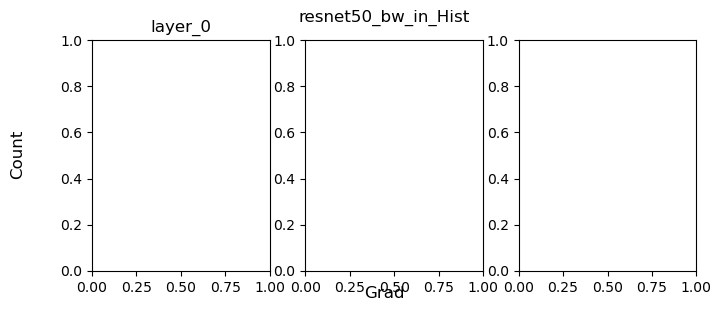

In [ ]:

target_layers = [0,1,2]
fig, axes = plt.subplots(1, len(target_layers), figsize=(len(target_layers)*2.6, 3))
axes_flat = axes.flat
fig.suptitle(f"{model}_{order}_{direction}_Hist")
fig.supxlabel("Grad")
fig.supylabel("Count")

for target_layer in target_layers: 
    channel_rv = torch.stack([f[target_layer] for f in features])
    channel_rv.size()
    ax = next(axes_flat)
    ax.set_title(f'layer_{target_layer}')
    hist_plot(channel_rv, ax, max_channels=50, num_features=2000, bins=30, alpha=0.5, )
plt.tight_layout()
